In [29]:
import torch
from datasets import *
import os
import pyreadr
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

In [2]:
DATASET_FOLDER_PATH = "dataset/RData"

# faulty_train = torch.load(os.path.join(TORCH_DATASET_FOLDER_PATH, "TEP_Faulty_Training.torch"), weights_only= True)
# faulty_test = torch.load(os.path.join(TORCH_DATASET_FOLDER_PATH, "TEP_Faulty_Testing.torch"), weights_only= True)
# faultfree_train = torch.load(os.path.join(TORCH_DATASET_FOLDER_PATH, "TEP_FaultFree_Training.torch"), weights_only= True)
# faultfree_test = torch.load(os.path.join(TORCH_DATASET_FOLDER_PATH, "TEP_FaultFree_Testing.torch"), weights_only= True)
faulty_train_df = pyreadr.read_r(os.path.join(DATASET_FOLDER_PATH, "TEP_Faulty_Training.RData"))["faulty_training"]

faultfree_train_df = pyreadr.read_r(os.path.join(DATASET_FOLDER_PATH, "TEP_FaultFree_Training.RData"))["fault_free_training"]



In [30]:
df = pd.concat((faultfree_train_df, faulty_train_df))

In [31]:
df[df["faultNumber"] == 1].head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,1.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,1.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,1.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [32]:
# processed_data = df.loc[df["sample"] <= 40]
processed_data = df
processed_data = processed_data[processed_data["faultNumber"] != 3]
processed_data = processed_data[processed_data["faultNumber"] != 9]
processed_data = processed_data[processed_data["faultNumber"] != 15]

np_dataset = processed_data.to_numpy().reshape((len(pd.unique(processed_data["faultNumber"])),
                                                len(pd.unique(processed_data["simulationRun"])),
                                                len(pd.unique(processed_data["sample"])),
                                                55))
print(np_dataset.shape)
print(len(processed_data))
# processed_data.head()

(18, 500, 500, 55)
4500000


In [37]:
sample_count = 40
width = 5
stride = 3
lookahead = 5
start_idx_range = range(0, sample_count-width-lookahead, stride)

x_shape = list(np_dataset.shape)
x_shape[-2] = len(start_idx_range)
x_shape.insert(-1, width)
y_shape = list(x_shape)

x_shape[-1] = 52
y_shape = y_shape[:-1]
y_shape[-1] = 1

x_dataset = np.zeros(x_shape, dtype=np.float32)
y_dataset = np.zeros(y_shape, dtype=np.float32)
print(x_dataset.shape)
print(y_dataset.shape)
idx = 0

for start_idx in start_idx_range:
    x_dataset[:, :, idx, :, :] = np_dataset[:, :, start_idx:start_idx+width, 3:]
    y_dataset[:, :, idx, :] = np_dataset[:, :, start_idx+width+lookahead, 0:1]
    idx += 1
# data.head(50)
# print(x_dataset.shape)
print(x_dataset[1, 0, 0, :, 0])



(18, 500, 10, 5, 52)
(18, 500, 10, 1)
[0.25038 0.25109 0.25038 0.24977 0.29405]


In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

reshaped_x_dataset = x_dataset.reshape((-1, *x_dataset.shape[-2:]))
reshaped_y_dataset = y_dataset.reshape((-1, y_dataset.shape[-1]))

print(reshaped_x_dataset.shape)
print(reshaped_y_dataset.shape)

sc = StandardScaler()
enc = OneHotEncoder(sparse_output=False)
x_scaled = sc.fit_transform(reshaped_x_dataset.reshape(-1, reshaped_x_dataset.shape[-1])).reshape(reshaped_x_dataset.shape)
y_enc = enc.fit_transform(reshaped_y_dataset)

print(x_scaled.shape)
print(y_enc.shape)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_scaled.astype(np.float32), y_enc.astype(np.float32), train_size=0.2, random_state=42)


(90000, 5, 52)
(90000, 1)
(90000, 5, 52)
(90000, 18)


In [36]:
with open("dataset/dataset_pm.npy", "wb") as f:
    print(x_train.dtype)
    print(y_train.dtype)
    print(x_val.dtype)
    print(y_val.dtype)
    np.save(f, x_train)
    np.save(f, y_train)
    np.save(f, x_val)
    np.save(f, y_val)


float32
float32
float32
float32


Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.1559 - loss: 2.6854 - val_accuracy: 0.2076 - val_loss: 2.4587
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2122 - loss: 2.4483 - val_accuracy: 0.2164 - val_loss: 2.4148
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2260 - loss: 2.3907 - val_accuracy: 0.2218 - val_loss: 2.3959
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2457 - loss: 2.3515 - val_accuracy: 0.2217 - val_loss: 2.3930
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2619 - loss: 2.3090 - val_accuracy: 0.2294 - val_loss: 2.3974
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2756 - loss: 2.2592 - val_accuracy: 0.2326 - val_loss: 2.3854
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2890 - loss: 2.2097 - val_accuracy: 0.2341 - val_loss: 2.4004
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2932 - loss: 2.1765 - val_accuracy: 0

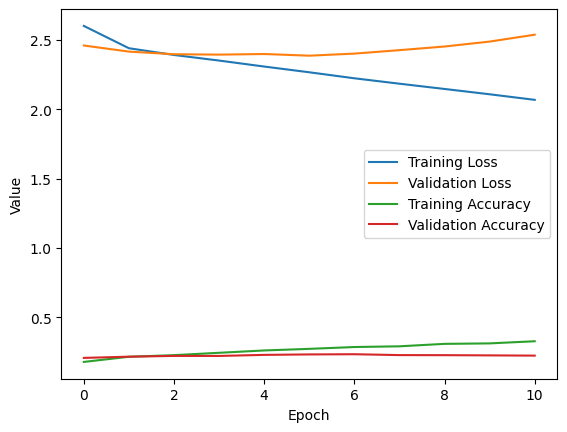

In [39]:

def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(64,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(64, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(128, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()